In [98]:
### Import 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno # To get visual representation of missing values

import math
import scipy.stats as stats
from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM

import sklearn.compose 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore') # To ignore the warnings

In [99]:
%matplotlib inline
sns.set_style(style='whitegrid')
sns.set_context(context ='notebook')
plt.rcParams['figure.figsize'] = (11, 9.4)

# Logistic Regression Assumptions

### Basic pre-processing


In [100]:
df = pd.read_csv('../../data//interim/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
# Create a categorical variable for traveling alone
df['TravelAlone'] = np.where((df['SibSp'] + df['Parch']) > 0, 0, 1).astype('uint8')

# Drop the redundant columns
df.drop('SibSp', axis=1, inplace=True)
df.drop('Parch', axis=1, inplace=True)
df.drop('PassengerId', axis=1, inplace=True)
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.drop('Cabin', axis=1, inplace=True)

In [102]:
# Create a categorical variable for the port of embarkation
df_titanic = pd.get_dummies(
    df,
    columns=['Pclass', 'Embarked', 'Sex'],
    drop_first=True
)

# fill nan (median imputation)
df_titanic['Age'].fillna(df_titanic['Age'].median(), inplace=True)

df_titanic.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,False,True,False,True,True
1,1,38.0,71.2833,0,False,False,False,False,False
2,1,26.0,7.9250,1,False,True,False,True,False
3,1,35.0,53.1000,0,False,False,False,True,False
4,0,35.0,8.0500,1,False,True,False,True,True


Define dependent and independent variable

In [103]:
X_input = df_titanic.drop('Survived', axis=1)
y_target = df_titanic['Survived']


X_input = X_input.astype({col: 'int' for col in X_input.select_dtypes(include='bool').columns})


X_constant = sm.add_constant(X_input, prepend=False)

### Assumption 1 - appropriate outcome type 

In [104]:
print(y_target.nunique())

2


In [105]:
y_target.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

-There are only two outcomes (i.e. binary classification of survived or did not survive), so we will be using Binary Logistic Regression (which is the default method we use when we specify family=Binomial in our logit models earlier)
- Other types of Logistic Regression (where outcomes > 2) include:
    - Multinomial Logistic Regression: Target variable has three or more nominal categories such as predicting the type of Wine.
    
    - Ordinal Logistic Regression: Target variable has three or more ordinal categories such as restaurant or product rating from 1 to 5.
- More info: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

### Assumption 2 - Linearity of independent variables and log odds

### Box-tidwell test

- One of the important assumptions of logistic regression is the linearity of the logit over the continuous covariates. This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.
- The *Box-Tidwell transformation (test)* can be used to test the linearity in the logit assumption when performing logistic regression.
- It checks whether the logit transform is a linear function of the predictor, effectively adding the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction.
- A *statistically significant* p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated
- If one variable is indeed found to be non-linear, then we can resolve it by incorporating higher order polynomial terms for that variable in the regression analysis to capture the non-linearity (e.g. x^2) .- Another solution to this problem is the categorization of the independent variables. That is transforming metric variables to ordinal level and then including them in the model.

---

- Details on R implementation of Box-Tidwell test in R, please refer to the `Box-Tidwell-Test-in-R.ipynb` notebook
- There is no native Python package to run the Box Tidwell test (unlike in R), so we will be coding the test below manually

### Linealidad en el Logit

En regresión logística, **se asume que la relación entre las variables independientes continuas y el logit de la variable dependiente es lineal**. Esto significa que si graficaras la variable independiente contra el logit de la probabilidad de éxito (por ejemplo, la probabilidad de supervivencia), la relación debería ser una línea recta.

### ¿Qué significa el p-valor en este contexto?
- **P-valor alto (> 0.05):** No hay evidencia suficiente para decir que la relación entre la variable y el logit es no lineal. Esto significa que es probable que la relación sea lineal.
- **P-valor bajo (< 0.05):** Hay suficiente evidencia para sugerir que la relación no es lineal, es decir, la suposición de linealidad se viola.

In [106]:
# Box tidwell only works for positive values, hence, drop values where x = 0

df_titanic_2 = df_titanic.drop(df_titanic[df_titanic.Age == 0].index)
df_titanic_2 = df_titanic.drop(df_titanic[df_titanic.Fare == 0].index)

df_titanic_2.head()


,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,False,True,False,True,True
1,1,38.0,71.2833,0,False,False,False,False,False
2,1,26.0,7.9250,1,False,True,False,True,False
3,1,35.0,53.1000,0,False,False,False,True,False
4,0,35.0,8.0500,1,False,True,False,True,True


Logistic Regression with statsmodel - Inclusion of interaction term (logit transform) as part of Box-Tidwell test



In [107]:
df_titanic_lt = df_titanic_2.copy()

# define continuous variables
continuous_vars = ['Age', 'Fare']

# Add logit transform interaction terms (natural log) for continuous variables e.g Age * Log(Age)
for var in continuous_vars:
    df_titanic_lt[f'{var}:Log_{var}'] = df_titanic_lt[var].apply(lambda x: x * np.log(x)) # np.log(x) is the natural log of x

df_titanic_lt.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Age:Log_Age,Fare:Log_Fare
0,0,22.0,7.2500,0,False,True,False,True,True,68.002934,14.362261
1,1,38.0,71.2833,0,False,False,False,False,False,138.228274,304.141753
2,1,26.0,7.9250,1,False,True,False,True,False,84.710510,16.404927
3,1,35.0,53.1000,0,False,False,False,True,False,124.437182,210.922595
4,0,35.0,8.0500,1,False,True,False,True,True,124.437182,16.789660


In [108]:
# keep columns related to continuous variables
cols_to_keep = continuous_vars + [f'{var}:Log_{var}' for var in continuous_vars]
cols_to_keep

['Age', 'Fare', 'Age:Log_Age', 'Fare:Log_Fare']

In [109]:
# Redefine independent variables to include interaction terms

X_input_lt = df_titanic_lt[cols_to_keep]
y_target_lt = df_titanic_lt['Survived']

# Add constant to the model
X_constant_lt = sm.add_constant(X_input_lt, prepend=False)

# Build the model and fit the data (using statsmodels logit)
logit_results = GLM(y_target_lt, X_constant_lt, family=sm.families.Binomial()).fit()

# Display the summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  876
Model:                            GLM   Df Residuals:                      871
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -536.19
Date:                Tue, 27 Aug 2024   Deviance:                       1072.4
Time:                        16:35:47   Pearson chi2:                     881.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1065
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.1123      0.058     -1.948

- We are interested in the p-values for the logit transformed interaction terms of `Age:Log_Age` and Fare:Log_Fare
- From the summary table above, we can see that the p value for Fare:`Log_Fare` is <0.001, which is statistically significant, whereas Age:`Log_Age` is not
- This means that there is non-linearity in the `Fare` feature, and the assumption has been violated
- We can resolve this by including a polynomial term (e.g. `Fare^2`) to account for the non-linearity

### Visual Check

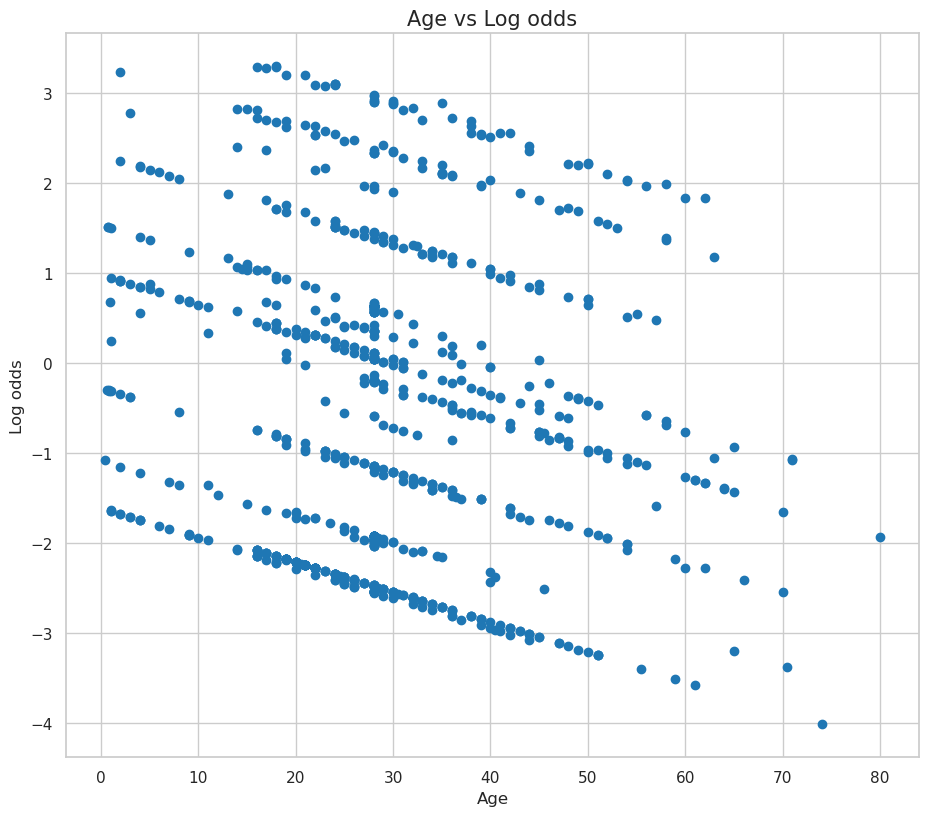

In [114]:
# Re-run logistic regression on original data set of X and y variables

logit_results = GLM(y_target, X_constant, family=sm.families.Binomial()).fit()
predicted = logit_results.predict(X_constant)

# get log adds values 
log_odds = np.log(predicted/(1-predicted))

# visualize predictor continuos variables vs logit values (Age)
plt.scatter(x=X_constant['Age'].values, y=log_odds)
plt.xlabel('Age')
plt.ylabel('Log odds')
plt.title('Age vs Log odds', fontsize=15)
plt.show()

Confirming that there is logit linearity for the Age variable (Recall earlier that p value for Age:Log Age is 0.101)



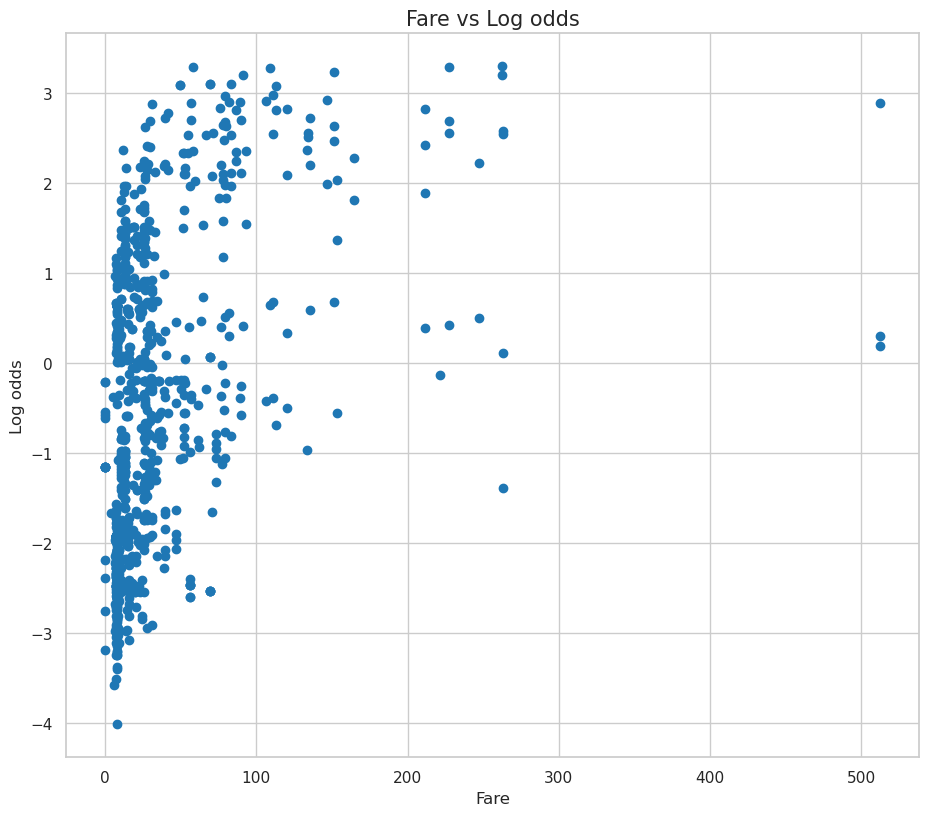

In [115]:
# Visualize predictor variable vs logit values (Fare)
plt.scatter(x=X_constant['Fare'].values, y=log_odds)
plt.xlabel('Fare')
plt.ylabel('Log odds')
plt.title('Fare vs Log odds', fontsize=15)
plt.show()

Confirming that there is logit NON-linearity for the `Fare` variable (Recall earlier that p value for Fare:Log Fare is <0.001)



### Assumption 3 - No strongly influential outliers

- Influential values are extreme individual data points that can alter the quality of the logistic regression model.
- Cook’s Distance is an estimate of the influence of a data point. It takes into account both the leverage and residual of each observation. Cook’s Distance is a summary of how much a regression model changes when the ith observation is removed.
- A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be influential (https://www.statology.org/cooks-distance-python/ and https://www.scikit-yb.org/en/latest/api/regressor/influence.html?highlight=cook#module-yellowbrick.regressor.influence), though there are even more generic cutoff values of >0.5-1.0.
- For outliers, we can use the absolute standardized residuals to identify them (std resid > 3)
- Reference: https://www.statsmodels.org/dev/examples/notebooks/generated/influence_glm_logit.html

In [117]:
# Use GLM method for logreg here so that we can retrieve the influence measures 
logit_models = GLM(y_target, X_constant, family=sm.families.Binomial())
logit_results = logit_models.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.95
Date:                Tue, 27 Aug 2024   Deviance:                       797.91
Time:                        17:42:44   Pearson chi2:                     933.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3536
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0333      0.008     -4.397      

In [122]:
from scipy import stats

# get influence measures
influence = logit_results.get_influence()

# obtain summary df of influence measures
summ_df = influence.summary_frame()

# filter summary df to cook distance
diagnosis_df = summ_df.loc[:, ['cooks_d']]

# Append absolute standardized residuals values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:, 'std_resid'].apply(lambda x: np.abs(x))

# sort by cook's distance
diagnosis_df.sort_values('cooks_d', ascending=False)
diagnosis_df

,cooks_d,std_resid
0,0.000041,0.330871
1,0.000046,0.243040
2,0.001006,0.866265
3,0.000091,0.313547
4,0.000017,0.280754
...,...,...
886,0.000292,0.589428
887,0.000049,0.225427
888,0.001102,1.029623
889,0.001417,0.763489


In [127]:
# set cook's distance threshold
cook_threshold = 4 / len(X_input)
print(f'Cook\'s distance threshold: {cook_threshold}')

Cook's distance threshold: 0.004489337822671156


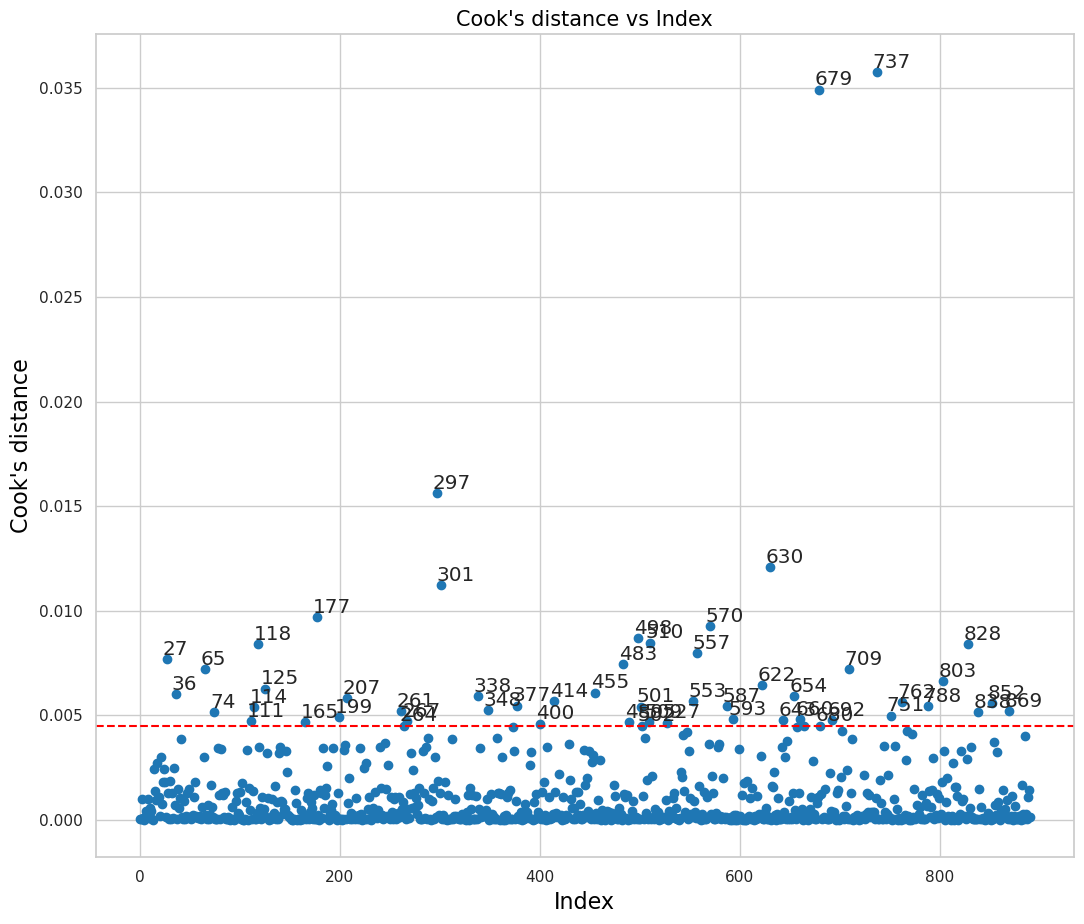

In [133]:
# plot influence measures (cook's distance)

fig = influence.plot_index(y_var='cooks_d', threshold=cook_threshold)
plt.axhline(y=cook_threshold, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Cook\'s distance')
plt.title('Cook\'s distance vs Index', fontsize=15)
fig.tight_layout()
plt.show()

In [137]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round((len(outliers) / len(X_input))*100,1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 6.1%


In [139]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df['cooks_d'] > cook_threshold) & (diagnosis_df['std_resid'] > 3)
]

prop_extreme = round((len(extreme) / len(X_input))*100,1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 1.3%


In [140]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
297,0.015636,4.951289
570,0.009277,3.030644
498,0.008687,3.384369
338,0.005917,4.461842
414,0.005666,4.387731


In [141]:
# Deep dive into index 297 (extreme outlier)
X_input.iloc[297]

Age              2.00
Fare           151.55
TravelAlone      0.00
Pclass_2         0.00
Pclass_3         0.00
Embarked_Q       0.00
Embarked_S       1.00
Sex_male         0.00
Name: 297, dtype: float64

In [143]:
y_target.iloc[297]  # 0 = Did not survive


0

- It is important to note that for data points with relative high Cook's distances, it does not automatically mean that it should be immediately removed from the dataset. It is essentially an indicator to highlight which data points are worth looking deeper into, to understand whether they are true anomalies or not
- In practice, an assessment of “large” values is a judgement call based on experience and the particular set of data being analyzed.
- In addition, based on our pre-defined threshold (4/N), only 5% (51/891) of the points are in the outlier zone, which is small as well. The issue comes when there is a significant number of data points classified as outliers.
- The management of outliers is outside the scope of this demo

### Assumption 4 - Absence of multicollinearity


<Axes: >

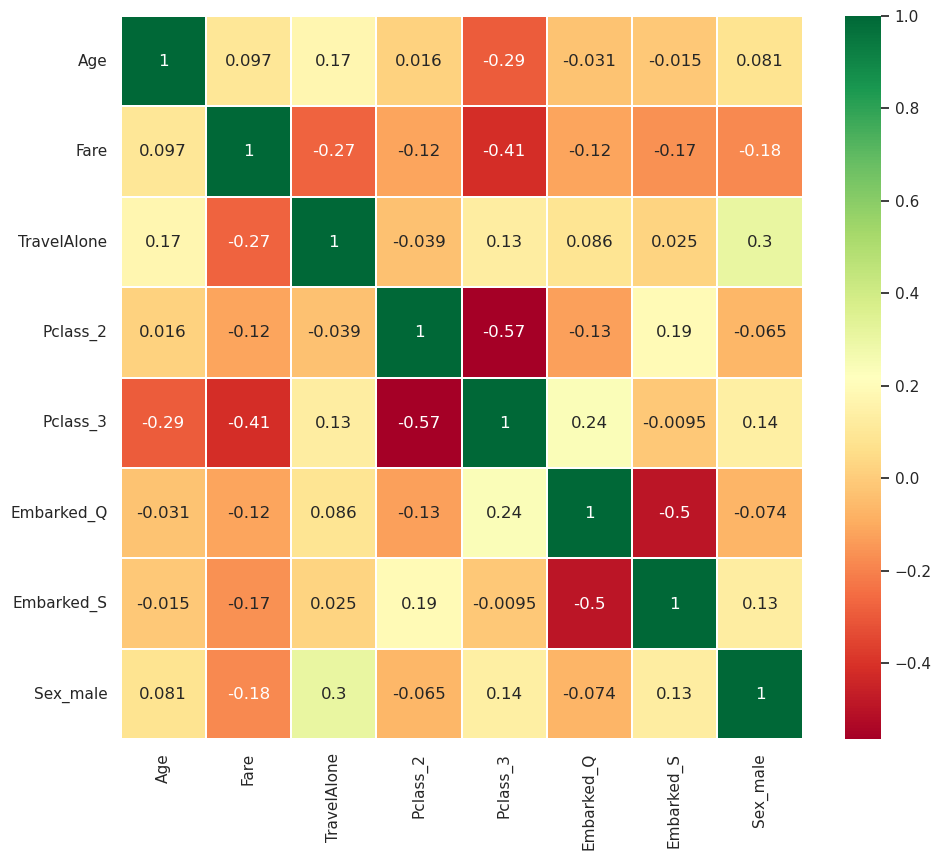

In [144]:
coor_matrix = X_input.corr()
sns.heatmap(coor_matrix, annot=True, cmap='RdYlGn', linewidths=0.2)

- Correlation matrix can be difficult to interpret when there are many independent variables
- Furthermore, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation.
 As such, we use Variance Inflation Factor (VIF) instead

**Variance Inflation Factor (VIF)**
Include constant in VIF calculation. Reference: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [147]:
# Use variance inflation factor to identify any significant multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

calc_vif(X_constant)

,variables,VIF
0,Age,1.214763
1,Fare,1.690016
2,TravelAlone,1.218899
3,Pclass_2,2.067296
4,Pclass_3,2.696852
5,Embarked_Q,1.491371
6,Embarked_S,1.484453
7,Sex_male,1.151131
8,const,24.218135


- The threshold for VIF is usually 5 (i.e. values above 5 means there is presence of multicollinearity)
- Since all the variables have VIF <5, it means that there is no multicollinearity, and this assumption is satisfied
- Let's have a look at the situation where we did not drop the first variable upon getting dummies:

In [154]:
# Avoid dropping first variables upon get_dummies
df_test = pd.get_dummies(
    df,
    columns=["Pclass","Embarked","Sex"],
    drop_first=False
)

df_test.drop('Sex_female', axis=1, inplace=True)
df_test.drop('Survived', axis=1, inplace=True) # Remove dependent variable from VIF calculation
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
df_test = df_test.assign(const=1)  # Add constant
df_test = df_test.astype({col: 'int' for col in df_test.select_dtypes(include='bool').columns})

calc_vif(df_test)

,variables,VIF
0,Age,1.217824
1,Fare,1.690035
2,TravelAlone,1.223104
3,Pclass_1,inf
4,Pclass_2,inf
5,Pclass_3,inf
6,Embarked_C,69.925063
7,Embarked_Q,36.785122
8,Embarked_S,91.277323
9,Sex_male,1.157472


- From the above results, we can see that there are numerous VIF values way above the threshold of 5 when we do not drop at least 1 category from the dummy categories we generated
- This is a clear sign of multicollinearity IF we do not drop first

### Assumption 5 - Independence of observations

- Error terms need to be independent. That is that the data-points should not be from any dependent samples design, e.g., before-after measurements, or matched pairings.


In [155]:
# Setup logistic regression model (using GLM method so that we can retrieve residuals)
logit_models = GLM(y_target, X_constant, family=sm.families.Binomial())
logit_results = logit_models.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.95
Date:                Tue, 27 Aug 2024   Deviance:                       797.91
Time:                        21:47:55   Pearson chi2:                     933.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3536
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0333      0.008     -4.397      

**Check residuals series**

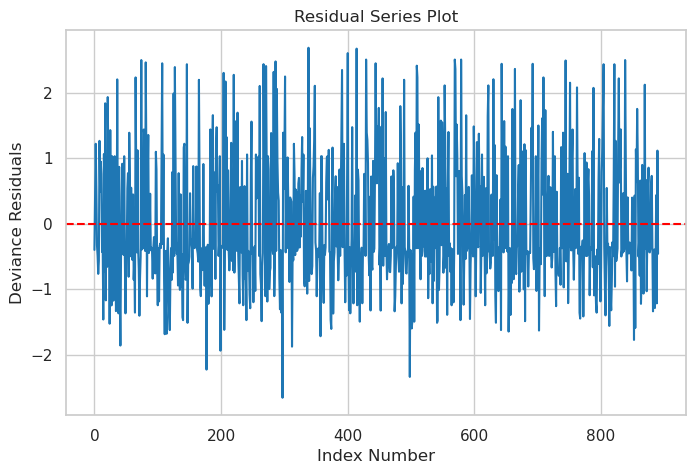

In [163]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111, title="Residual Series Plot",
                    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(X.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(X_input.index.tolist(), stats.zscore(logit_results.resid_deviance))
plt.axhline(y=0, ls="--", color='red');


- From the above Deviance residuals versus index number plot, we can see that the assumption of independence of errors is satisfied

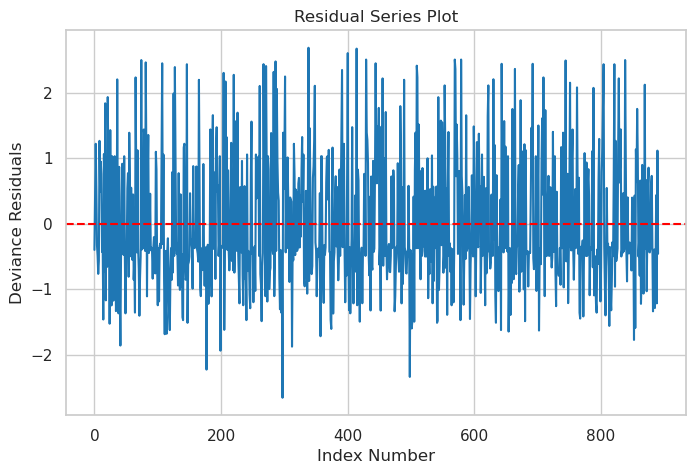

In [164]:
# Asumiendo que X_input y logit_results están definidos
residuals = stats.zscore(logit_results.resid_deviance)

# Crear el gráfico usando seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(x=X_input.index, y=residuals)

# Agregar una línea horizontal en y=0
plt.axhline(y=0, ls="--", color='red')

# Agregar título y etiquetas
plt.title("Residual Series Plot")
plt.xlabel("Index Number")
plt.ylabel("Deviance Residuals")

plt.show()

**Further investigation on residual dependence plots (Optional)**

- This is additional investigation. The above check on residuals series (based on index numbers) is sufficient
- Reference: https://freakonometrics.hypotheses.org/8210

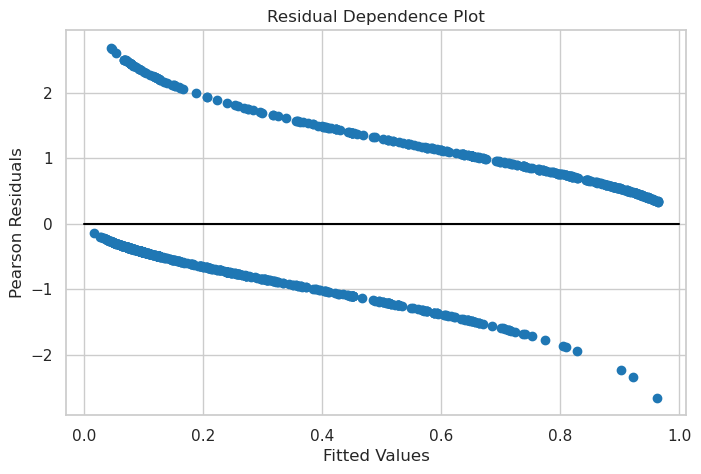

In [165]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(
            111,
            title="Residual Dependence Plot",
            xlabel="Fitted Values",
            ylabel="Pearson Residuals")

# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

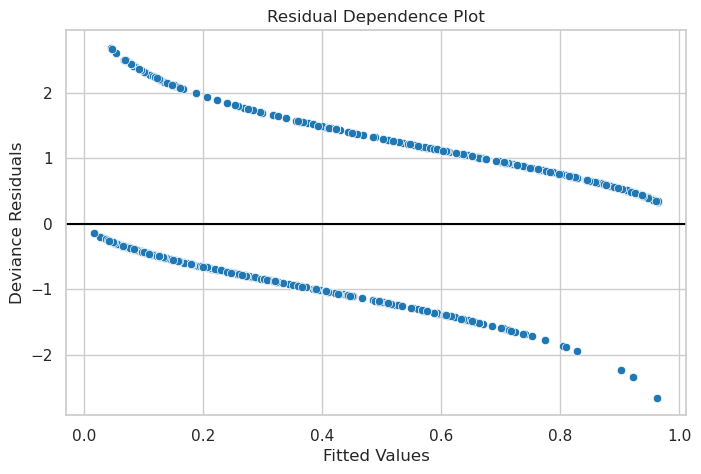

In [166]:
fitted_values = logit_results.mu
residuals = stats.zscore(logit_results.resid_deviance)

# Crear el gráfico usando seaborn
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_values, y=residuals)

# Agregar una línea horizontal en y=0
plt.axhline(y=0, color='black')

# Agregar título y etiquetas
plt.title("Residual Dependence Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Deviance Residuals")

plt.show()

**Add a Locally Weighted Scatterplot Smoothing (LOWESS) line to better visualize independence**



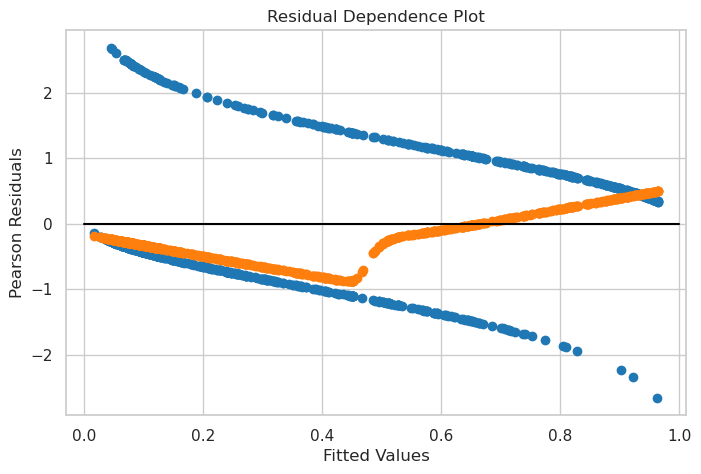

In [167]:
# Setup LOWESS function
lowess = sm.nonparametric.lowess

# Get y-values from LOWESS (set return_sorted=False)
y_hat_lowess = lowess(logit_results.resid_pearson, logit_results.mu, 
                      return_sorted = False,
                      frac=2/3)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals")

# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.scatter(logit_results.mu, y_hat_lowess)
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

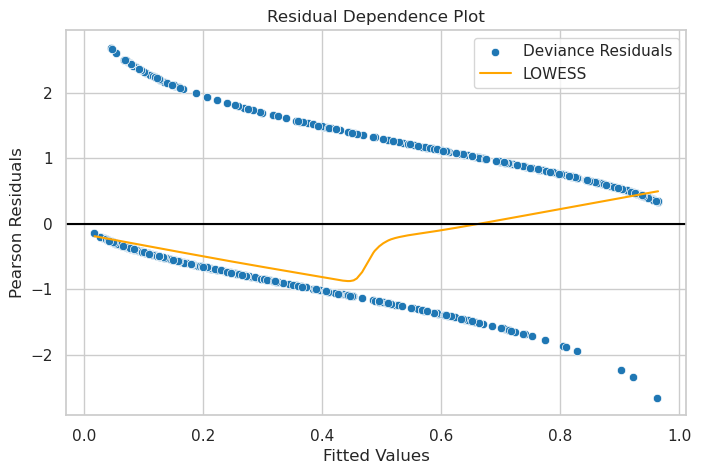

In [168]:
fitted_values = logit_results.mu
residuals = stats.zscore(logit_results.resid_deviance)

# Configuración de la función LOWESS
lowess = sm.nonparametric.lowess
y_hat_lowess = lowess(logit_results.resid_pearson, fitted_values, 
                      frac=2/3, return_sorted=False)

# Crear el gráfico usando Seaborn para scatter y Matplotlib para LOWESS
plt.figure(figsize=(8, 5))

# Gráfico de dispersión de los residuales
sns.scatterplot(x=fitted_values, y=residuals, label='Deviance Residuals')

# Agregar los valores suavizados de LOWESS
sns.lineplot(x=fitted_values, y=y_hat_lowess, color='orange', label='LOWESS')

# Línea horizontal en y=0
plt.axhline(y=0, color='black')

# Agregar título y etiquetas
plt.title("Residual Dependence Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")

plt.legend()
plt.show()

**Assumption 6 - Sufficiently large sample size**

In [170]:
# Find total number of observations
len(X_input)

891

In [174]:
# Get value counts for independent variables (mainly focus on categorical)
for col in X_input.columns.to_list()[1:]:
    if X_input.dtypes[col] == 'uint8': # Keep categorical variables only
        print(X_input[col].value_counts())

TravelAlone
1    537
0    354
Name: count, dtype: int64


- Rule of thumb is to have at least 10-20 instances of the least frequent outcome for each predictor variable in your model

- From the value counts above, we can see that this assumption is satisfied

- Another rule of thumb is to have at least 500 observations in the entire dataset

- Overall, we have 891 observations, which is a decent dataset size to work with